## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [16]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
# Step through the list and search for chessboard corners
def getCalibrationParameters(listFileimage, listX, listY):
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = []
    for i in range(len(listFileimage)):
        fname = 'camera_cal/' + listFileimage[i]
        x = listX[i]
        y = listY[i]
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        objp = np.zeros((x*y,3), np.float32)
        objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)
        ret, corners = cv2.findChessboardCorners(gray, (x,y),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (x,y), corners, ret)
        images.append(img)
        
    return objpoints, imgpoints, images

## And so on and so forth...

In [18]:
def warp(img, inv = False):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [
            [1280-580, 445],   # top right
            [1280-  0, 720],   # bottom right
            [       0, 720],   # bottom left
            [     580, 445]    # top left

        ]
    )
    dst = np.float32(
       [
            [950,   0],   # top right
            [950, 720],   # bottom right
            [   0, 720],   # bottom left
            [   0,   0]    # top left
        ]
    )
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    if not inv:
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warped
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped


In [19]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [20]:
def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [21]:
def findmasklines(warped, window_width = 50, window_height = 80, margin = 100):

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = template
    
    # If no window centers found, just display orginal road image
    else:
        output = None
    
    return output

In [22]:
def enqueue_left(A_left, B_left, C_left):
    
    global A_left_hist
    global B_left_hist
    global C_left_hist
    
    A_left_hist.insert(0, A_left)
    B_left_hist.insert(0, B_left)
    C_left_hist.insert(0, C_left)
    if len(A_left_hist) > N:
        del A_left_hist[-1]
        del B_left_hist[-1]
        del C_left_hist[-1]

        
def enqueue_right(A_right, B_right, C_right):
    global A_right_hist
    global B_right_hist
    global C_right_hist

    A_right_hist.insert(0, A_right)
    B_right_hist.insert(0, B_right)
    C_right_hist.insert(0, C_right)
    
    if len(A_right_hist) > N:
        del A_right_hist[-1]
        del B_right_hist[-1]
        del C_right_hist[-1]
    
    

In [23]:
def calculate_curvature(A, B, y = 720.0):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Calculate the new radii of curvature
    curv = ((1 + (2*A*y*ym_per_pix + B)**2)**1.5) / np.absolute(2*A)
    return curv


In [24]:
def calculate_center_dist(A, B, C, y = 720):
    return (A*y*y + B*y + C - 640) * 3.7 / 1000.0

In [25]:
def pipeline(img, mtx, dist, return_intermediate_imgs = False):
    
    global A_left_hist
    global B_left_hist
    global C_left_hist
    global A_right_hist
    global B_right_hist
    global C_right_hist
    
    intermediate_imgs = []
    label_intermediate_imgs = []
    
    img_und = cv2.undistort(img, mtx, dist, None, mtx)

    if return_intermediate_imgs:
        intermediate_imgs.append(img_und)
        label_intermediate_imgs.append('image undistort')
        
    img = img_und
    
    img_warped = warp(img)

    if return_intermediate_imgs:
        intermediate_imgs.append(img_warped)
        label_intermediate_imgs.append('image warped')



    img = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HLS)
    temp = img[:,:,2]
    s_channel = np.zeros((temp.shape[0], temp.shape[1], 3))
    s_channel[:,:,0] = 1-temp
    s_channel[:,:,1] = 1-temp
    s_channel[:,:,2] = 1-temp
    
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=1)

    if return_intermediate_imgs:
        intermediate_imgs.append(sobelx)
        label_intermediate_imgs.append('image sobelx')
        
    sobel_magnitude = np.sqrt(np.multiply(sobelx,sobelx))
    scaled_sobel = np.uint8(255*sobel_magnitude/np.max(sobel_magnitude))

    sbinary = np.zeros_like(sobelx)
    sbinary[(scaled_sobel >= 4) & (scaled_sobel <= 255)] = 1

    if return_intermediate_imgs:
        intermediate_imgs.append(sbinary)
        label_intermediate_imgs.append('image sbinary')

        
    sbinary_gray = np.uint8(255*sbinary[:,:,0])
    
    img_mask = findmasklines(sbinary_gray) #, window_width = 200, window_height = 100, margin = 200)
    if return_intermediate_imgs:
        intermediate_imgs.append(img_mask)
        label_intermediate_imgs.append('image img_mask')

    num_points_left  = 0
    x = []
    y = []
    for i in range(sbinary.shape[1]//2-30):
        for j in range(sbinary.shape[0]):
            if sbinary[j,i,0] > .4 and img_mask[j,i,1] == 255:
                x.append(float(j))
                y.append(float(i))
                num_points_left = num_points_left + 1
    poly_left = np.polynomial.polynomial.polyfit(x, y, 2)                
    
    num_points_right = 0
    x = []
    y = []
    for i in range(sbinary.shape[1]//2+30, sbinary.shape[1]):
        for j in range(sbinary.shape[0]):
            if sbinary[j,i,0] > .4 and img_mask[j,i,1] == 255:
                x.append(float(j))
                y.append(float(i))
                num_points_right = num_points_right + 1
    poly_right = np.polynomial.polynomial.polyfit(x, y, 2)    

    n_left  = len(A_left_hist)
    n_right = len(A_right_hist)

    '''
    if (abs(poly_left[2] - poly_right[2]) / (abs(poly_left[2]) + abs(poly_right[2]) + 0.0001)) < 0.3 or n_left == 0 or n_right == 0:
        enqueue_left(poly_left[2], poly_left[1], poly_left[0])
        enqueue_right(poly_right[2], poly_right[1], poly_right[0])
    else:
        if num_points_left > num_points_right:
            enqueue_left(poly_left[2], poly_left[1], poly_left[0])
            enqueue_right(poly_left[2], poly_left[1], poly_left[0] + 640)
        else: 
            enqueue_left(poly_right[2], poly_right[1], poly_right[0] - 640)
            enqueue_right(poly_right[2], poly_right[1], poly_right[0])

    '''

    enqueue_left(poly_left[2], poly_left[1], poly_left[0])
    enqueue_right(poly_left[2], poly_left[1], poly_left[0] + 640)

    
    n_left  = len(A_left_hist)
    n_right = len(A_right_hist)
    
    poly_img = np.zeros((img_warped.shape[0], img_warped.shape[1], 3), dtype=np.uint8)
    A_left_mean  = sum(A_left_hist)  /n_left
    B_left_mean  = sum(B_left_hist)  /n_left
    C_left_mean  = sum(C_left_hist)  /n_left
    A_right_mean = sum(A_right_hist) /n_right
    B_right_mean = sum(B_right_hist) /n_right
    C_right_mean = sum(C_right_hist) /n_right
    
    for j in range(poly_img.shape[0]):
        n = float(len(C_left_hist))
        y_left  = C_left_mean  + B_left_mean *float(j) + A_left_mean *float(j)*float(j)
        y_right = C_right_mean + B_right_mean*float(j) + A_right_mean*float(j)*float(j)
        for i in range(poly_img.shape[1]):
            if (y_left - float(i)) < 0 and (y_right - float(i)) > 0:
                poly_img[j,i,1] = 255

    if return_intermediate_imgs:
        intermediate_imgs.append(poly_img)
        label_intermediate_imgs.append('image poly_img')

    img_lane_unwarped = warp(poly_img, True)

    if return_intermediate_imgs:
        intermediate_imgs.append(img_lane_unwarped)
        label_intermediate_imgs.append('image unwarp poly_img')
        
    R_left  = calculate_curvature(A_left_mean,  B_left_mean,  y = 720.0)
    R_right = calculate_curvature(A_right_mean, B_right_mean, y = 720.0)
    
    D_left  = calculate_center_dist(A_left_mean,  B_left_mean,  C_left_mean)
    D_right = calculate_center_dist(A_right_mean, B_right_mean, C_right_mean)


    img = cv2.addWeighted(img_und, 1.0, img_lane_unwarped, 0.5, 0)
    return poly_img, R_left, D_left, R_right, D_right, intermediate_imgs, label_intermediate_imgs, poly_left[2], poly_left[1], poly_left[0], poly_right[2], poly_right[1], poly_right[0]

In [26]:

objpoints, imgpoints, images = getCalibrationParameters(
    [
        'calibration1.jpg',  'calibration2.jpg',  'calibration3.jpg',
        'calibration4.jpg',  'calibration5.jpg',  'calibration6.jpg',
        'calibration7.jpg',  'calibration8.jpg',  'calibration9.jpg',
        'calibration10.jpg', 'calibration11.jpg', 'calibration12.jpg',
        'calibration13.jpg', 'calibration14.jpg', 'calibration15.jpg',
        'calibration16.jpg', 'calibration17.jpg', 'calibration18.jpg',
        'calibration19.jpg', 'calibration20.jpg'        
    ], 
    [
        9,9,9,    #  1  2  3 
        9,9,9,    #  4  5  6
        9,9,9,    #  7  8  9
        9,9,9,    # 10 11 12
        9,9,9,    # 13 14 15
        9,9,9,    # 16 17 18
        9,9       # 19 20
    ], 
    [
        6,6,6,    #  1  2  3
        6,5,6,    #  4  5  6 
        6,6,6,    #  7  8  9
        6,6,6,    # 10 11 12
        6,6,6,    # 13 14 15
        6,6,6,    # 16 17 18
        6,6       # 19 20
    ])





In [27]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720, 1280),None,None)


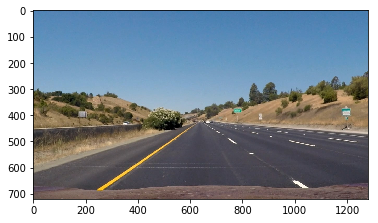

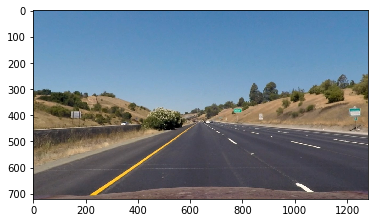

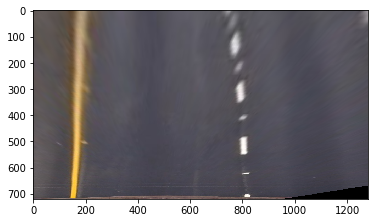

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


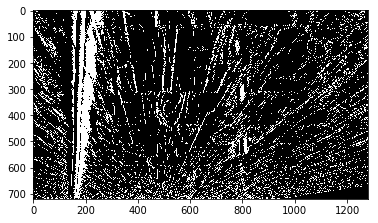

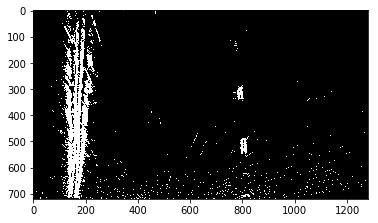

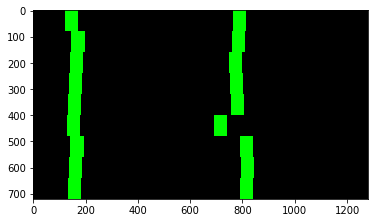

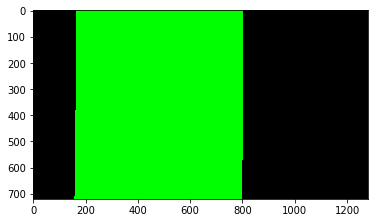

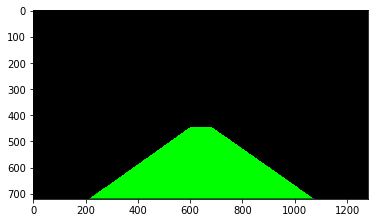

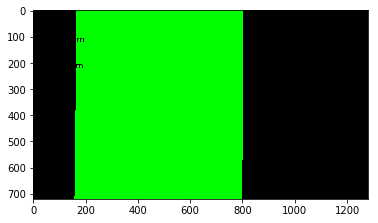

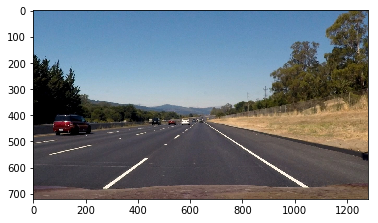

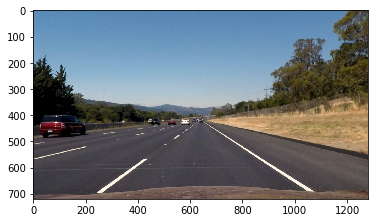

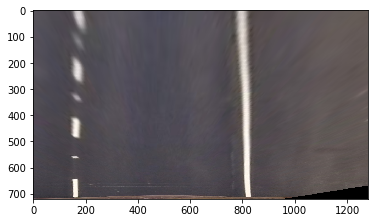

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


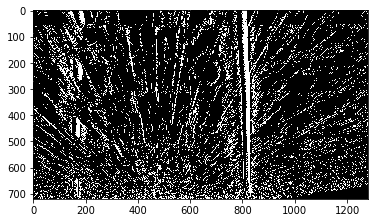

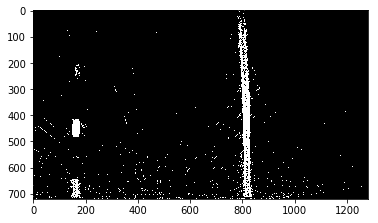

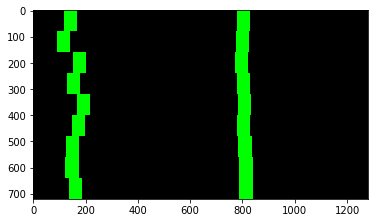

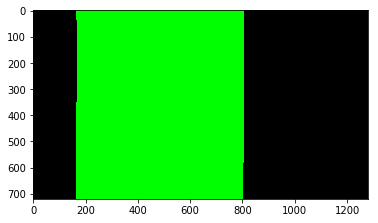

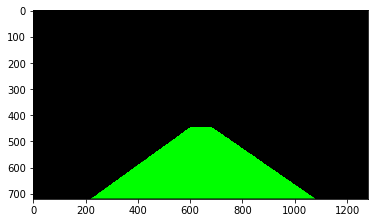

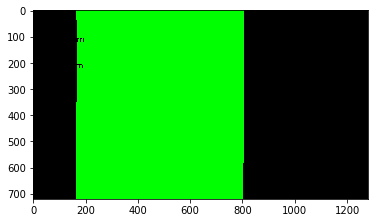

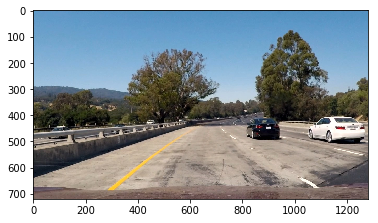

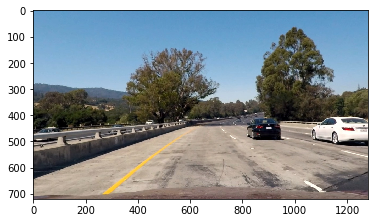

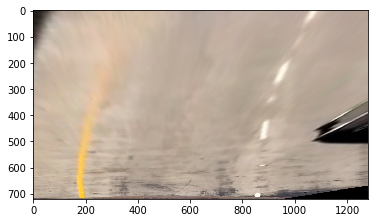

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


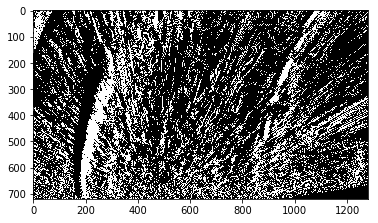

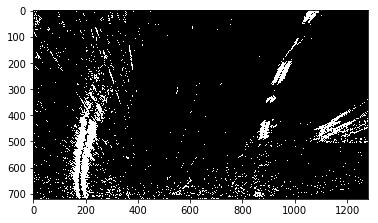

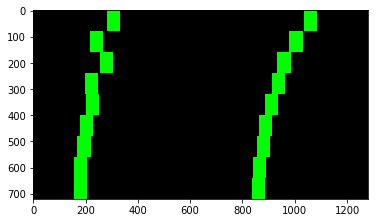

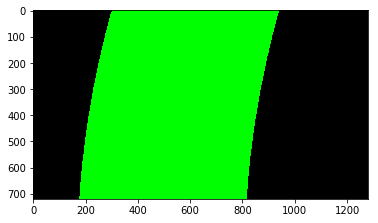

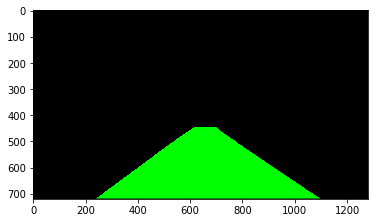

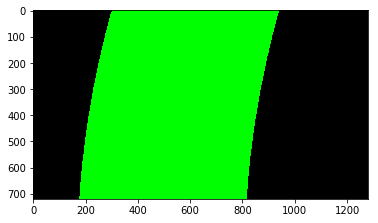

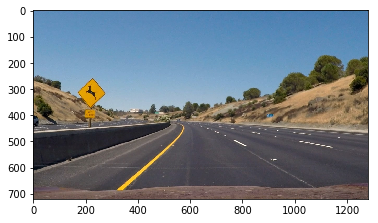

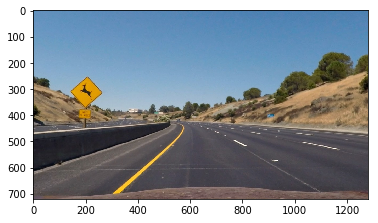

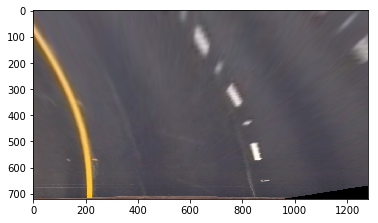

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


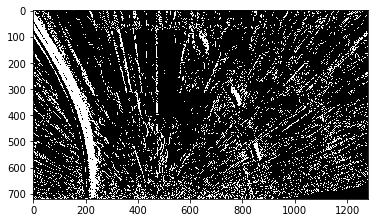

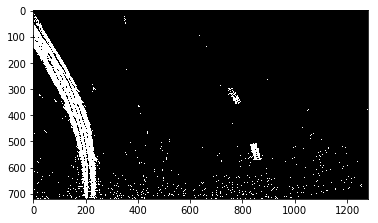

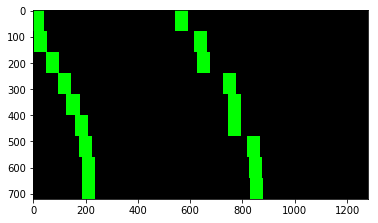

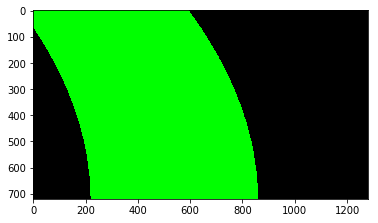

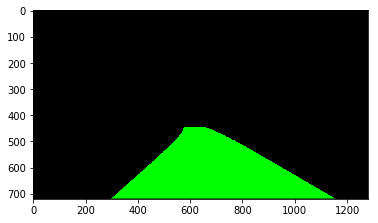

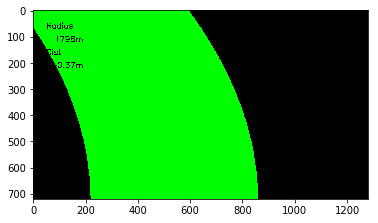

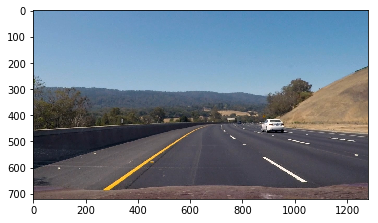

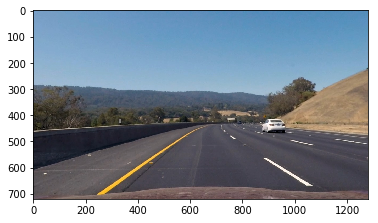

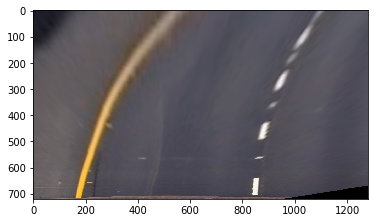

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


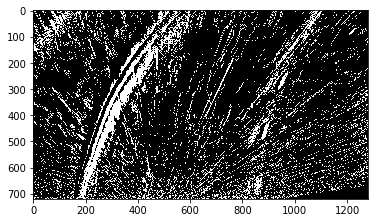

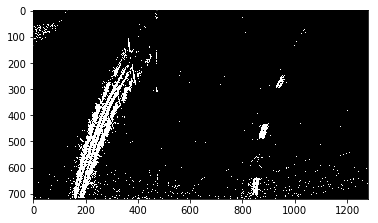

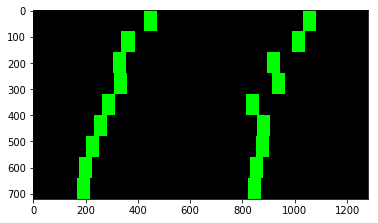

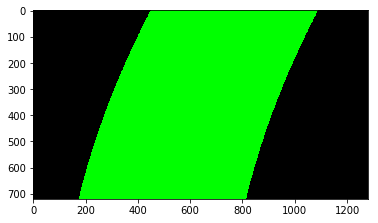

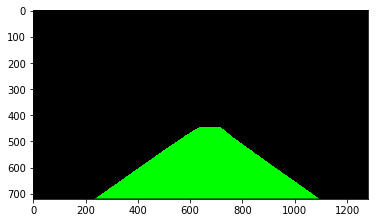

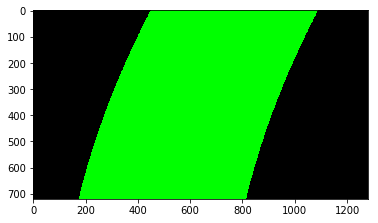

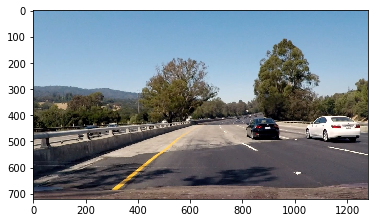

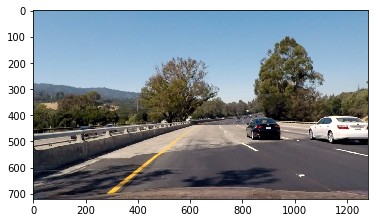

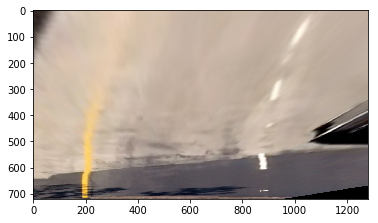

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


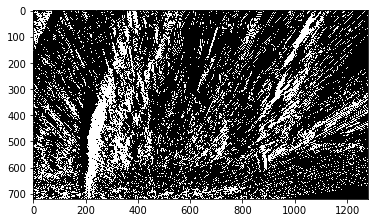

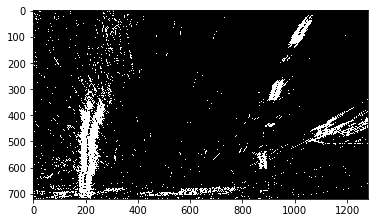

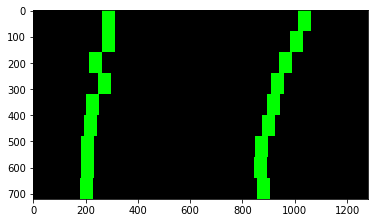

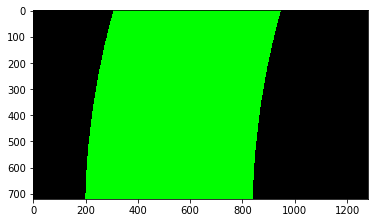

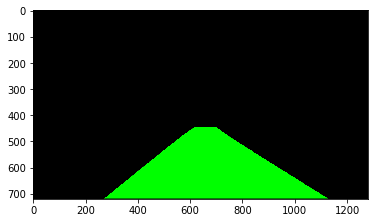

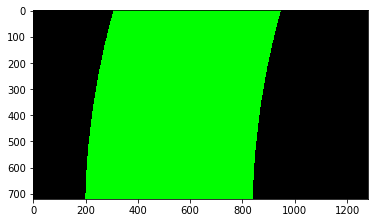

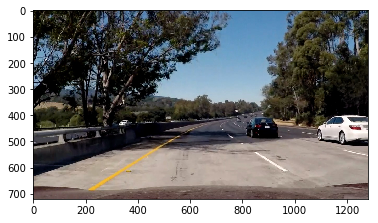

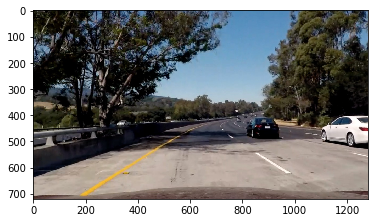

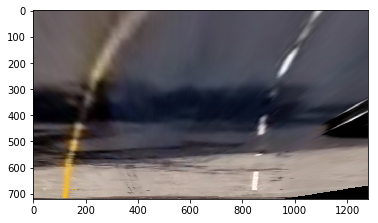

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


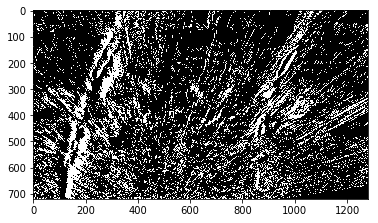

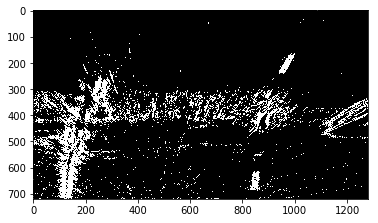

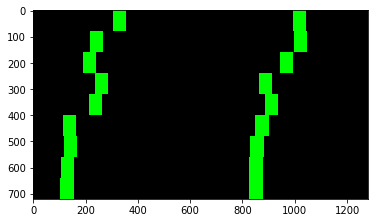

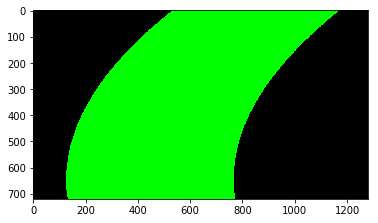

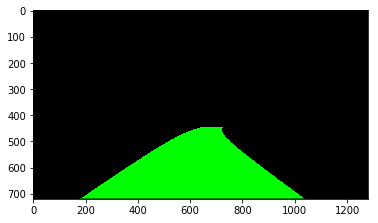

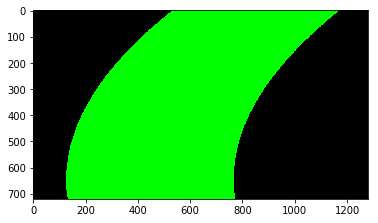

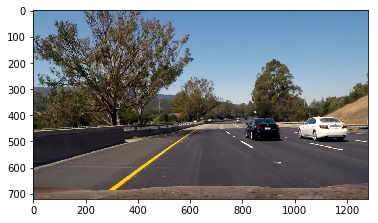

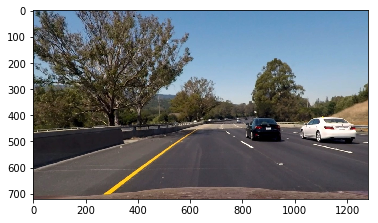

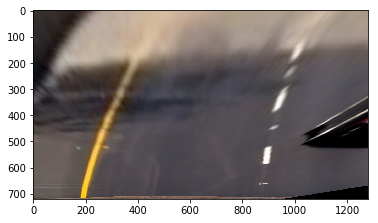

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


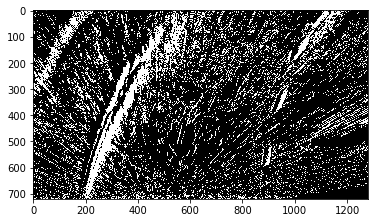

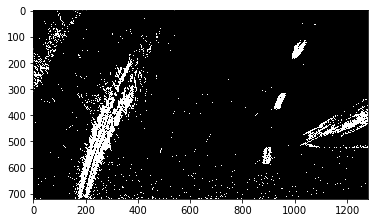

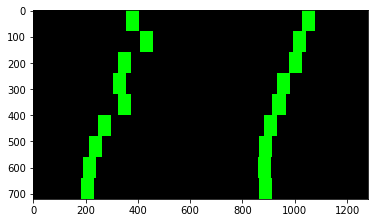

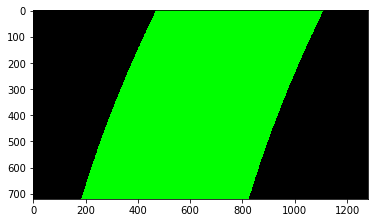

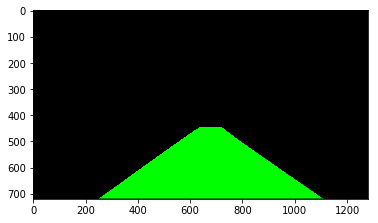

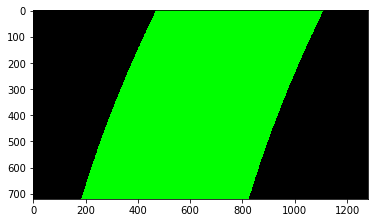

In [28]:
N = 20
A_left_hist = None
B_left_hist = None
C_left_hist = None
A_right_hist = None
B_right_hist = None
C_right_hist = None

def erase_coeff_hist():
    global A_left_hist
    global B_left_hist
    global C_left_hist
    global A_right_hist
    global B_right_hist
    global C_right_hist
    A_left_hist  = []
    B_left_hist  = []
    C_left_hist  = []
    A_right_hist = []
    B_right_hist = []
    C_right_hist = []
    
for fileimage in [
    'straight_lines1', 'straight_lines2', 'test1', 
    'test2', 'test3', 'test4', 'test5', 'test6']:
    img = cv2.imread('test_images' + os.sep + fileimage + '.jpg')
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    erase_coeff_hist()
    img, R_left, D_left, R_right, D_right, intermediate_imgs, label_intermediate_imgs, A_left, B_left, C_left, A_right, B_right, C_right = pipeline(img, mtx, dist, True)
    for i in range(len(intermediate_imgs)):
        plt.imshow(intermediate_imgs[i])
        plt.show() 
        cv2.imwrite('output' + os.sep + fileimage + '_' + str(i) + '.jpg', intermediate_imgs[i])
    cv2.putText(img, "Radius"                              ,   (  50,  70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    cv2.putText(img, "%6.0fm" % ( (R_left + R_right) / 2.0) ,  (  50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    cv2.putText(img, "Dist"                                ,   (  50, 170), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    cv2.putText(img, "%6.2fm" % ( (D_left + D_right) / 2.0) ,  (  50, 220), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    plt.imshow(img)
    plt.show()    
    cv2.imwrite('output' + os.sep + fileimage + '_F' + '.jpg', img)
        


In [29]:
def process_image(img):
    img, R_left, D_left, R_right, D_right, _, _, A_left, B_left, C_left, A_right, B_right, C_right = pipeline(img, mtx, dist)
    cv2.putText(img, "Radius"                              ,  (  50,  70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    cv2.putText(img, "%6.0fm" % ( (R_left + R_right) / 2.0) ,  (  50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    cv2.putText(img, "Dist"                                ,  (  50, 170), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    cv2.putText(img, "%6.2fm" % ( (D_left + D_right) / 2.0) ,  (  50, 220), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    return img
    





In [30]:
make_video = True
if make_video:
    white_output = 'output'  + os.sep + 'project_video.mp4'
    clip = VideoFileClip("project_video.mp4")
    erase_coeff_hist()
    white_clip = clip.fl_image(process_image) 
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output\project_video.mp4
[MoviePy] Writing video output\project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [43:13<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output\project_video.mp4 

Wall time: 43min 14s
